In [1]:
import pandas as pd 
import numpy as np 
import gc 
import lightgbm as lgb

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline

load basic features 

In [3]:
%%time 
df_train = pd.read_pickle('../input/feats/df_trn_feat0.pkl')
df_test = pd.read_pickle('../input/feats/df_test_feat0.pkl')

CPU times: user 44 ms, sys: 200 ms, total: 244 ms
Wall time: 720 ms


In [4]:
df_train['price_log1'] = df_train.price.apply(np.log1p)
df_test['price_log1'] = df_test.price.apply(np.log1p)

load text features

In [5]:
%%time 
with pd.HDFStore('../input/feats/txt_td_tfidf_hash5.h5') as store:
    print(store.keys())
    df_trn_text_feat  = store['df_trn_text_feat']
    df_test_text_feat = store['df_test_text_feat']

['/df_test_text_feat', '/df_trn_text_feat']
CPU times: user 76 ms, sys: 196 ms, total: 272 ms
Wall time: 866 ms


load text features2

In [6]:
# %%time 
# with pd.HDFStore('../input/feats/txt_svd_feat2.h5') as store:
#     print(store.keys())
#     df_trn_text_feat  = store['df_trn_text_feats']
#     df_test_text_feat = store['df_test_text_feats']

['/df_test_text_feats', '/df_trn_text_feats']
Wall time: 75.1 ms


load fm features 

In [6]:
# %%time 
# with pd.HDFStore('../input/feats/fm_uidx_rc_cnt_lat2.h5') as store:
#     print(store.keys())
#     df_fm_uidx_rc_cnt_lat2 = store['fm_uidx_rc_cnt_lat2']

In [7]:
# df_fm_uidx_rc_cnt_lat2.head().T

In [8]:
# df_train = df_train.merge(df_fm_uidx_rc_cnt_lat2,how='left',on=['uidx','region_city_label'])
# df_test = df_test.merge(df_fm_uidx_rc_cnt_lat2,how='left',on=['uidx','region_city_label'])

In [9]:
# df_train['cnt_by_uidx_rc'] = df_train['cnt'].astype('float16')
# df_train.drop('cnt',axis=1,inplace=True)

load interaction tsvd features

In [10]:
# %%time 
# with pd.HDFStore('../input/feats/feat2_trn_inter_svd.h5') as store:
#     print(store.keys())
#     df_trn_inter_svd = store['df_trn_inter_svd']
#     df_test_inter_svd = store['df_test_inter_svd']

load zero prediction

In [11]:
# %%time 
# cut_off = 0.8
# meta_zero_pred = np.load('../input/feats/meta_zero_deal.npy')
# df_zero_pred = pd.DataFrame({'pred_zero':meta_zero_pred})

# df_zero_pred['pred_zero'] = df_zero_pred.pred_zero > cut_off

cnt by uidx param1

In [12]:
# df_cnt_uidx_param1 = df_train.groupby(['uidx','param_1']).size().astype('uint16').reset_index().rename(columns={0:'cnt_by_uidx_param1'})
# df_train = df_train.merge(df_cnt_uidx_param1,how='left',on=['uidx','param_1'])
# df_train['cnt_by_uidx_param1'] = df_train.cnt_by_uidx_param1.fillna(0).astype('uint16')

cnt by uidx category name

In [13]:
# df_cnt_uidx_cat = df_train.groupby(['uidx','category_name']).size().astype('uint16').reset_index().rename(columns={0:'cnt_by_uidx_cat'})
# df_train = df_train.merge(df_cnt_uidx_cat,how='left',on=['uidx','category_name'])
# df_train['cnt_by_uidx_cat'] = df_train.cnt_by_uidx_cat.fillna(0).astype('uint16')

In [14]:
# df_train.cnt_by_uidx_cat.head()

mean encode category features

In [6]:
# %%time 
# with pd.HDFStore('../input/feats/df_mean_target.h5') as store:
#     print(store.keys())
#     df_trn_mean_target = store['df_trn_mean_target']
# #     df_trn_mean_target = store['df_trn_mean_LOO'] ### LOO mean ## serious overfit !!!
#     df_test_mean_target = store['df_test_mean_target']
#     df_nfold_idx = store['df_nfold_idx']

['/df_nfold_idx', '/df_test_mean_target', '/df_trn_mean_target']
Wall time: 175 ms


In [7]:
# nfold_idx = df_nfold_idx.to_dict()

In [6]:
%%time 
with pd.HDFStore('../input/feats/df_mean_target_cv2.h5') as store:
    print(store.keys())
    df_trn_mean_target = store['df_trn_encoded']
    df_test_mean_target = store['df_test_encoded']    

['/df_test_encoded', '/df_trn_encoded']
CPU times: user 32 ms, sys: 56 ms, total: 88 ms
Wall time: 285 ms


combine features

In [7]:
%%time
# df_train = pd.concat([df_train, df_trn_text_feat ],axis=1)
# df_test = pd.concat([df_test,df_test_text_feat],axis=1)
# df_train = pd.concat([df_train,df_trn_text_feat,df_trn_inter_svd], axis=1)
# df_train = pd.concat([df_train, df_zero_pred],axis=1)
# df_train = pd.concat([df_train,df_trn_mean_target],axis=1)

df_train = pd.concat([df_train, df_trn_text_feat, df_trn_mean_target],axis=1)
df_test = pd.concat([df_test,df_test_text_feat, df_test_mean_target],axis=1)

CPU times: user 344 ms, sys: 116 ms, total: 460 ms
Wall time: 458 ms


In [8]:
df_train.columns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'deal_probability', 'price_log1', 'title_tfidf_0', 'title_tfidf_1',
       'title_tfidf_2', 'title_tfidf_3', 'title_tfidf_4', 'title_hash_0',
       'title_hash_1', 'title_hash_2', 'title_hash_3', 'title_hash_4',
       'desc_tfidf_0', 'desc_tfidf_1', 'desc_tfidf_2', 'desc_tfidf_3',
       'desc_tfidf_4', 'desc_hash_0', 'desc_hash_1', 'desc_hash_2',
       'desc_hash_3', 'desc_hash_4', 'mean_uidx', 'mean_iidx',
       'mean_region_city_label', 'mean_param_1', 'mean_param_2',
       'mean_param_3', 'mean_user_type', 'mean_parent_category_name',
       'mean_category_name', 'mean_image_top_1'],
      dtype='object')

In [9]:
# df_test.columnsns

Index(['uidx', 'iidx', 'iid', 'region_city_label', 'tit_len', 'desc_len',
       'activation_date', 'month', 'day', 'weekday', 'param_1', 'param_2',
       'param_3', 'user_type', 'parent_category_name', 'price',
       'category_name', 'image_top_1', 'ads_cnt_by_uid', 'ads_cnt_by_iid',
       'price_log1', 'title_tfidf_0', 'title_tfidf_1', 'title_tfidf_2',
       'title_tfidf_3', 'title_tfidf_4', 'title_hash_0', 'title_hash_1',
       'title_hash_2', 'title_hash_3', 'title_hash_4', 'desc_tfidf_0',
       'desc_tfidf_1', 'desc_tfidf_2', 'desc_tfidf_3', 'desc_tfidf_4',
       'desc_hash_0', 'desc_hash_1', 'desc_hash_2', 'desc_hash_3',
       'desc_hash_4', 'mean_uidx', 'mean_iidx', 'mean_region_city_label',
       'mean_param_1', 'mean_param_2', 'mean_param_3', 'mean_user_type',
       'mean_parent_category_name', 'mean_category_name', 'mean_image_top_1'],
      dtype='object')

In [25]:
selcols = [
    'uidx','iidx',
    'tit_len','desc_len',
    'mean_region_city_label',
    'month','day','weekday',
    'mean_param_1','mean_param_2','mean_param_3',
    'mean_user_type','mean_parent_category_name','mean_category_name',
#     'mean_iidx',
#     'user_type','parent_category_name','category_name',
    'mean_image_top_1',
    'ads_cnt_by_uid','ads_cnt_by_iid',    
    'price_log1'
]

text_cols = ['title_tfidf_{}'.format(e) for e in range(5)] + \
['title_hash_{}'.format(e) for e in range(5)] + \
['desc_tfidf_{}'.format(e) for e in range(5)] + \
['desc_hash_{}'.format(e) for e in range(5)]            

selcols += text_cols

In [26]:
# selcols = list(df_train.columns)

# drop_cols = [
#                 'deal_probability','activation_date','iid','price'
#                 'uidx','iidx',
#                 'region_city_label',
#                 'month','day','weekday',
#                 'param_1',
#                 'param_2',
#                 'param_3',
#                 'image_top_1',
#                 'user_type','parent_category_name','category_name',
                
#                 'mean_param_2','mean_param_3'
#             ]
#                 'mean_uidx','mean_iidx',
#                 'mean_param_1',
#                 'mean_user_type','mean_parent_category_name','mean_category_name','mean_image_top_1'
            
# drop_cols += ['title_tfidf_{}'.format(e) for e in range(2,5)] + \
#             ['title_hash_{}'.format(e) for e in [0]] +\
#             ['desc_tfidf_{}'.format(e) for e in [1,4]] + \
#             ['desc_hash_{}'.format(e) for e in [1,3,4]] 

# selcols = [col for col in selcols if col not in drop_cols]

X_train = df_train[selcols].copy()
y_train = df_train['deal_probability']
X_test  = df_test[selcols].copy()



In [27]:
print('shape of X_train:',X_train.shape)
print('shape of X_test :',X_test.shape)

shape of X_train: (1503424, 38)
shape of X_test : (508438, 38)


In [28]:
X_train.columns

Index(['uidx', 'iidx', 'tit_len', 'desc_len', 'mean_region_city_label',
       'month', 'day', 'weekday', 'mean_param_1', 'mean_param_2',
       'mean_param_3', 'mean_user_type', 'mean_parent_category_name',
       'mean_category_name', 'mean_image_top_1', 'ads_cnt_by_uid',
       'ads_cnt_by_iid', 'price_log1', 'title_tfidf_0', 'title_tfidf_1',
       'title_tfidf_2', 'title_tfidf_3', 'title_tfidf_4', 'title_hash_0',
       'title_hash_1', 'title_hash_2', 'title_hash_3', 'title_hash_4',
       'desc_tfidf_0', 'desc_tfidf_1', 'desc_tfidf_2', 'desc_tfidf_3',
       'desc_tfidf_4', 'desc_hash_0', 'desc_hash_1', 'desc_hash_2',
       'desc_hash_3', 'desc_hash_4'],
      dtype='object')

##### KFold

use built-in `lgb.cv`

In [29]:
# categorical = None
categorical = ['month','day','weekday'
#                'param_1','param_2','param_3',
#                'region_city_label', 
#                'image_top_1',
#                'user_type','category_name','parent_category_name'
              ]

lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',     
    'max_depth': 15,
    'num_leaves': 33,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,    
    'learning_rate': 0.1        
}  

predictors = list(X_train.columns)



dtrain = lgb.Dataset(X_train, label=y_train, feature_name=predictors, categorical_feature=categorical)
cv_results = lgb.cv(lgbm_params, dtrain,                     
                    nfold=4,
                    stratified=False,
                    num_boost_round=10000,
                    early_stopping_rounds=20,                    
                    verbose_eval=100)
print('done')

/home/ihong/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	cv_agg's rmse: 0.22571 + 0.000191692
[200]	cv_agg's rmse: 0.224805 + 0.000172649
[300]	cv_agg's rmse: 0.224311 + 0.000176002
[400]	cv_agg's rmse: 0.224028 + 0.000205623
[500]	cv_agg's rmse: 0.223806 + 0.000202142
[600]	cv_agg's rmse: 0.223614 + 0.000227949
[700]	cv_agg's rmse: 0.223473 + 0.000216093
[800]	cv_agg's rmse: 0.223354 + 0.000209432
[900]	cv_agg's rmse: 0.223247 + 0.000209819
[1000]	cv_agg's rmse: 0.223165 + 0.000216286
[1100]	cv_agg's rmse: 0.223093 + 0.000218658
[1200]	cv_agg's rmse: 0.223033 + 0.000195838
[1300]	cv_agg's rmse: 0.222974 + 0.000197513
[1400]	cv_agg's rmse: 0.222935 + 0.000197164
[1500]	cv_agg's rmse: 0.222902 + 0.000189589
[1600]	cv_agg's rmse: 0.222878 + 0.000192099
[1700]	cv_agg's rmse: 0.222852 + 0.000192903
[1800]	cv_agg's rmse: 0.222826 + 0.00020772
done


In [30]:
bst_iter = np.argmin(cv_results['rmse-mean']) 
bst_cv   = np.min(cv_results['rmse-mean'])
print('bst_iter:{}\tcv:{:.4}'.format(bst_iter,bst_cv))

bst_iter:1875	cv:0.2228


___

simple train/test split 

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [32]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train,y_train,test_size=0.2, random_state=1)

lgtrain = lgb.Dataset(X_trn, y_trn,                    
                    categorical_feature = categorical)
lgvalid = lgb.Dataset(X_val, y_val,                
                categorical_feature = categorical)

lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',     
    'max_depth': 15,
    'num_leaves': 33,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,    
    'learning_rate': 0.1,
    'num_boost_round': 10000, 
    'categorical':categorical
}  

# Go Go Go
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
#     num_boost_round=n_rounds,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=100
)
print("Model Evaluation Stage")
print('RMSE:', np.sqrt(mean_squared_error(y_val, lgb_clf.predict(X_val))))



/home/ihong/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:98: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ihong/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.225002	valid's rmse: 0.22592
[200]	train's rmse: 0.223299	valid's rmse: 0.224981
[300]	train's rmse: 0.222095	valid's rmse: 0.224504
[400]	train's rmse: 0.220915	valid's rmse: 0.224082
[500]	train's rmse: 0.219898	valid's rmse: 0.223772
[600]	train's rmse: 0.219009	valid's rmse: 0.223593
[700]	train's rmse: 0.218206	valid's rmse: 0.223472
[800]	train's rmse: 0.217414	valid's rmse: 0.223366
[900]	train's rmse: 0.216635	valid's rmse: 0.223256
[1000]	train's rmse: 0.215888	valid's rmse: 0.223193
[1100]	train's rmse: 0.215196	valid's rmse: 0.22312
[1200]	train's rmse: 0.214493	valid's rmse: 0.223056
[1300]	train's rmse: 0.213778	valid's rmse: 0.222994
[1400]	train's rmse: 0.213098	valid's rmse: 0.222929
[1500]	train's rmse: 0.212437	valid's rmse: 0.22289
[1600]	train's rmse: 0.211811	valid's rmse: 0.22286
[1700]	train's rmse: 0.211159	valid's rmse: 0.222817
[1800]	train's rmse: 0.2105	valid's rmse: 0.222796

In [44]:
lgb_clf.best_iteration

1701

_____

In [33]:
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

In [34]:
class LgbWrapper:
    ## copy from https://www.kaggle.com/mmueller/stacking-starter
    def __init__(self, params=None):
        
        self.num_boost_round = params.pop('num_boost_round', 100)
        self.categorical = params.pop('categorical',None)
#         self.verbose_eval = params.pop('verbose_eval', False)
        self.params = params
        
    def train(self, x_train, y_train):
        dtrain = lgb.Dataset(x_train, label=y_train, feature_name=list(x_train.columns), categorical_feature=self.categorical)
        self.gbdt = lgb.train(self.params,
                              dtrain, self.num_boost_round
                              )
    def predict(self, x):
        return self.gbdt.predict(x)
                

In [35]:
def get_oof(x_train, y_train, x_test, clf, nfolds=4, num_bucket=100, seed=0):
    ## modify from https://www.kaggle.com/mmueller/stacking-starter
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    
    ## continuous stratified kfold
    percentiles = np.percentile(y_train, np.linspace(0, 100, num_bucket)) ## create percentiles 
    falls_into = np.searchsorted(percentiles,y_train) ## fall into bucket
    
    skf = StratifiedKFold(nfolds, random_state=seed) ## random state
    skf.get_n_splits(x_train, falls_into)
        
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((nfolds, ntest))

    for i, (train_index, test_index) in enumerate(skf.split(x_train, falls_into)):
        x_tr = x_train.iloc[train_index,:].copy()
        y_tr = y_train[train_index]
        x_te = x_train.iloc[test_index,:].copy()

        clf.train(x_tr, y_tr) ## x_tr must be dataframe

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [18]:
# def get_oof2(x_train,y_train, x_test,clf, nfold_idx):
    
#     ## modify from https://www.kaggle.com/mmueller/stacking-starter
#     ntrain = x_train.shape[0]
#     ntest = x_test.shape[0]
    
#     nfolds = len(nfold_idx)
    
    
#     oof_train = np.zeros((ntrain,))
#     oof_test = np.zeros((ntest,))
#     oof_test_skf = np.empty((nfolds, ntest))

#     for i in nfold_idx:
#         trn_idx = nfold_idx[i]['tr_idx']
#         val_idx = nfold_idx[i]['val_idx']
                
#         x_tr = x_train.iloc[trn_idx,:].copy()
#         y_tr = y_train[trn_idx]
#         x_te = x_train.iloc[val_idx,:].copy()

#         clf.train(x_tr, y_tr) ## x_tr must be dataframe

#         oof_train[val_idx] = clf.predict(x_te)
#         oof_test_skf[i, :] = clf.predict(x_test)

#     oof_test[:] = oof_test_skf.mean(axis=0)
#     return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [36]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',     
    'max_depth': 15,
    'num_leaves': 33,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,    
    'learning_rate': 0.1,
    'num_boost_round': bst_iter, 
    'categorical':categorical
}  


lgb_clf = LgbWrapper(params=lgbm_params)

lgb_oof_train, lgb_oof_test = get_oof(X_train, y_train, X_test,lgb_clf)
# lgb_oof_train, lgb_oof_test = get_oof2(X_train, y_train, X_test, lgb_clf, nfold_idx)
print('oof train rmse:{:.4f}'.format(mean_squared_error(lgb_oof_train,y_train)**0.5)) ### rmse 


/home/ihong/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


oof train rmse:0.2229


In [37]:
pd.DataFrame({'name':lgb_clf.gbdt.feature_name(),'split':lgb_clf.gbdt.feature_importance()}).sort_values(by='split',ascending=False)

,name,split
17,price_log1,3851
14,mean_image_top_1,3143
4,mean_region_city_label,2931
6,day,2814
0,uidx,2373
8,mean_param_1,2337
16,ads_cnt_by_iid,1957
22,title_tfidf_4,1936
3,desc_len,1809
36,desc_hash_3,1757


# submission

##### history
1. local cv:  0.2216 (lb: 0.2276 overfit?)
    - text(20) + mean_target + basic
2. local cv:  0.2238 (lb: 0.2272)
    - text + basic
3. local cv:  0.223 (lb: 0.2264) v
    - modify image_top_1 to cat
4. local cv:  0.2178 (lb: 0.2268 overfit)
    - (text+basic) + mean (nfolds=100)
5. local cv:  0.2201 (lb: 0.2273 overfit...)
    - modify mean with same out of fold idx
6. local cv:  0.2213 (lb: 0.2280 overfit)
    - mean without strified kfolds (use only kfold=4)
7. local cv:  0.2231 (lb: 0.2274 )
    - mean encode cv2 (only used)
        - 'mean_region_city_label',
        - 'mean_user_type', 
        - 'mean_parent_category_name', 
        - 'mean_category_name',
        - 'mean_image_top_1
8. local cv: 0.1647 (lb: 0.2383)
9. local cv: 0.2233 (lb: 0.2275)
10. local cv: 0.2228 (lb: 0.2275)
11. local cv: 0.2226 (lb: 0.2278)
12 local cv :0.2229 (lb:)

In [38]:
df_test2 = pd.read_pickle('../input/test.pkl')
itemid = df_test2.item_id 

In [39]:
y_pred = pd.DataFrame()
y_pred['item_id'] = itemid
y_pred['deal_probability'] = lgb_oof_test.ravel().clip(0,1)

In [40]:
y_pred.head()

,item_id,deal_probability
0,6544e41a8817,0.065426
1,65b9484d670f,0.202836
2,8bab230b2ecd,0.169748
3,8e348601fefc,0.158123
4,8bd2fe400b89,0.160662


In [41]:
fileno = 12
y_pred.to_csv('../output/sub/sub_{}.csv'.format(fileno),index=False)

____

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [15]:
NFOLDS = 4
kf = KFold(n_splits=NFOLDS,random_state=0)
rmse_results = []
# def oof:
for nfold,(trn_idx, val_idx) in enumerate(kf.split(X_train)):
    x_trn, y_trn = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    x_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    dtrain = lgb.Dataset(x_trn,y_trn, feature_name=predictors, categorical_feature=categorical)
    dval   = lgb.Dataset(x_val,y_val, feature_name=predictors, categorical_feature=categorical)
    
    lgb_clf = lgb.train(lgbm_params,num_boost_round = 10000,
                        train_set = dtrain,
                        valid_sets = [dtrain, dval] ,                        
                        early_stopping_rounds=10,
                        verbose_eval= 0)
    y_pred = lgb_clf.predict(x_val)
    rmse = (mean_squared_error(y_pred,y_val))**0.5
    print('fold:{},\trmse:\t{:.4f}'.format(nfold,rmse))
    rmse_results.append(rmse)
print('mean rmse : \t{:.4f}'.format(np.mean(rmse_results) ))

fold:0,	rmse:	0.2239
fold:1,	rmse:	0.2239
fold:2,	rmse:	0.2248
fold:3,	rmse:	0.2259
mean rmse : 	0.2246


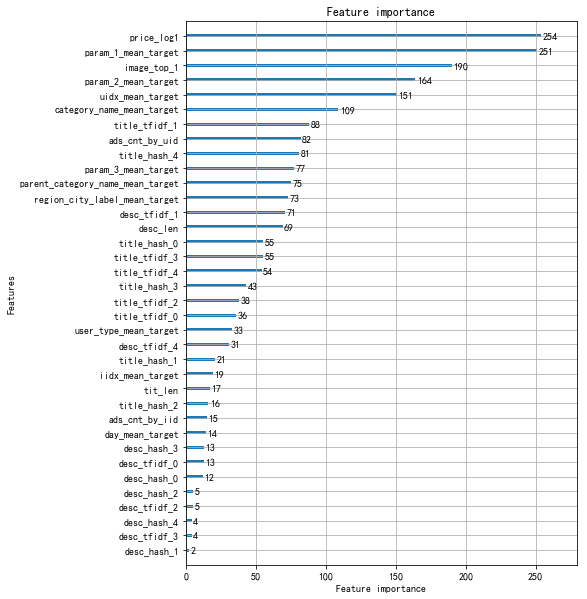

In [16]:
# feat_names = lgb_clf.feature_name()
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf,max_num_features=50, ax=ax)
# pd.DataFrame({'feat_idx':range(len(feat_names))})

In [40]:
feat_imp = pd.DataFrame({'f':lgb_clf.feature_name(),
                         'split':lgb_clf.feature_importance(importance_type='split'),
                         'gain':lgb_clf.feature_importance(importance_type='gain')}).sort_values(by='split',ascending=False)

In [43]:
feat_imp.head(20)

,f,gain,split
2,region_city_label,15100.792241,5988
8,param_1,35224.964765,3267
9,param_2,8581.022626,1205
10,param_3,3694.306379,1203
17,price_log1,5572.762249,1196
13,category_name,26133.717461,972
6,day,776.373718,828
14,image_top_1,3572.760681,659
16,ads_cnt_by_iid,2079.301587,414
27,title_hash_4,1430.029037,400


In [42]:
feat_imp.sort_values(by='gain',ascending=False).head(20)

,f,gain,split
8,param_1,35224.964765,3267
13,category_name,26133.717461,972
2,region_city_label,15100.792241,5988
9,param_2,8581.022626,1205
17,price_log1,5572.762249,1196
15,ads_cnt_by_uid,4348.241808,322
10,param_3,3694.306379,1203
14,image_top_1,3572.760681,659
16,ads_cnt_by_iid,2079.301587,414
27,title_hash_4,1430.029037,400


____